In [1]:
from collections import deque
import tqdm
import bench_utils
from shapely.geometry import shape
from algos.alg_fpd import Fpd
from algos.alg_fpd_extended import FpdExtended
import random
import numpy as np
from shapely.geometry import shape
from intersection.plotting import xs, ys
import shapely 

fpd = FpdExtended()

#df, _ = bench_utils.read_dataset("data/world_7_dec.json")
df, _ = bench_utils.read_dataset("data/sweden.json")

MEMORY_SLOTS = 4
USE_FLAT_LIST = True
NORMALIZE_PLACEMENT = True
VERTICES_PER_SHAPE = [4, 8] # Max 5 vertices
REQUIRED_IN_MEMORY = 4

# Export delta properties
x, y = [], []
bins = []
normalization_offset = []
for idx in tqdm.tqdm(range(len(df)), disable=True): # List of single idxs
    geom = shape(df.iloc[idx])
    num_coords = shapely.get_num_coordinates(geom)
    bounds = shapely.bounds(geom)
    normalization_offset.append([bounds[0], bounds[1]])
    _, bin = fpd.compress(geom)
    bins.append(bin)
    type = 0 if shapely.get_type_id(geom) == 1 else 0

    if num_coords < VERTICES_PER_SHAPE[0] or num_coords > VERTICES_PER_SHAPE[1]:
        continue

    chunks, _ = fpd.get_chunks(bin, include_ring_start=False)
    X_shape = []
    y_shape = []
    for c in chunks:
        if NORMALIZE_PLACEMENT:
            c = [[p[0] - bounds[0], p[1] - bounds[1]] for p in c]
        prevs = [(c[0])]
        for coord in c[1:]:
            if len(prevs) > MEMORY_SLOTS:
                prevs.pop()

            X_small = [prevs[i] if len(prevs) > i else [np.NaN, np.NaN] for i in range(MEMORY_SLOTS)]
            extra_features = [type, num_coords]
            y_small = coord
            prevs.insert(0, coord)

            if len(prevs) - 1 < REQUIRED_IN_MEMORY:
                continue

            if USE_FLAT_LIST:
                X_shape.append([*xs(X_small), *ys(X_small)] + extra_features)
            else:
                X_shape.append(X_small)
            y_shape.append(y_small)

    if len(X_shape) > 0:
        x.append((idx, X_shape))
        y.append(y_shape)

In [ ]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection
from sklearn.utils import shuffle
from sklearn.neural_network import MLPRegressor
x = np.array(x, dtype=object)
y = np.array(y, dtype=object)

In [ ]:
print(x.shape)
#X = X.reshape((-1, X.shape[1] * X.shape[2]))
#print(X.shape)
print(y.shape)

(17811, 2)
(17811,)


In [ ]:
print(x)
print(y)

[[0
  list([[0.0005439000000002636, 0.0007441999999997506, 0.0008014999999996775, 0.0, 0.0, 0.0, 0.00022890000000330701, 0.00022890000000330701, 0, 6]])]
 [3
  list([[0.0002364000000021349, 0.000385000000001412, 0.0001047000000014009, 0.0, 0.0, 0.00011010000000055697, 0.0002080000000006521, 0.00013039999999620022, 0, 7], [9.280000000089217e-05, 0.0002364000000021349, 0.000385000000001412, 0.0001047000000014009, 5.019999999689162e-05, 0.0, 0.00011010000000055697, 0.0002080000000006521, 0, 7]])]
 [6
  list([[0.0002631999999991308, 0.0004692999999988956, 0.00033809999999867557, 0.0, 7.509999999655292e-05, 0.0001923000000019215, 0.00026390000000020564, 7.169999999945276e-05, 0, 6]])]
 ...
 [99983
  list([[0.0011475999999994713, 0.0010998999999998205, 4.949999999936949e-05, 0.0, 0.00026569999999992433, 0.00028939999999977317, 0.000290499999998417, 0.00026259999999922456, 0, 8], [0.0011434000000001276, 0.0011475999999994713, 0.0010998999999998205, 4.949999999936949e-05, 1.139999999821839e-05

In [ ]:
X_train, X_validation, y_train, y_validation = model_selection.train_test_split(x, y, random_state=50,test_size=0.3)
X_validation, X_test, y_validation, y_test = model_selection.train_test_split(X_validation, y_validation, random_state=50,test_size=0.3)

def scramble_and_unpack(X, y):
    '''
    Returns the ID of the shape and scrambles the chunks within the data set.
    Note that the steps above are done in order to avoid overlap (using the same shape)
    between the different sets.
    '''
    X_shapes = [x[0] for x in X]
        
    X_stripped = [x[1] for x in X]
    X_stripped = [item for sublist in X_stripped for item in sublist]
    
    X_long_shapes = []
    for i in range(len(X_shapes)):
        X_long_shapes += [X_shapes[i] for _ in range(len(X[i][1]))]
    
    y_flat = [item for sublist in y for item in sublist]
    X_shapes, X_stripped, y_flat = shuffle(X_long_shapes, X_stripped, y_flat, random_state=0)

    X_stripped = np.array(X_stripped)
    y_flat = np.array(y_flat)

    return np.array(X_shapes), X_stripped, y_flat

train_geometries, X_train, y_train = scramble_and_unpack(X_train, y_train)
validation_geometries, X_validation, y_validation = scramble_and_unpack(X_validation, y_validation)
test_geometries, X_test, y_test = scramble_and_unpack(X_test, y_test)

print('train data shape:',np.shape(X_train))
print('validation data shape:',np.shape(X_validation))
print('train labels shape:',np.shape(y_train))
print('validation labels shape:',np.shape(y_validation))
print('test labels shape:',np.shape(X_test))
print('test labels shape:',np.shape(y_test))

train data shape: (25447, 10)
validation data shape: (7684, 10)
train labels shape: (25447, 2)
validation labels shape: (7684, 2)
test labels shape: (3297, 10)
test labels shape: (3297, 2)


In [ ]:
mean = np.mean(X_train, axis = 0)
std = np.std(X_train, axis = 0)

#train_data = (train_data-mean) / std
#validation_data = (validation_data-mean) / std

#print(train_data)
print(mean, std)

[6.82034452e-04 6.71061504e-04 5.82463497e-04 4.49898908e-04
 2.72265709e-04 3.16837081e-04 3.52030664e-04 3.32667269e-04
 0.00000000e+00 6.98392738e+00] [1.33936393e-03 1.26073818e-03 1.16275688e-03 1.13580072e-03
 5.45467374e-04 5.74337009e-04 6.63217468e-04 7.51945761e-04
 0.00000000e+00 8.49698716e-01]


In [ ]:
X_train[0]

array([2.6125e-03, 2.8217e-03, 5.9197e-03, 4.8843e-03, 5.6780e-04,
       2.8820e-04, 9.3690e-04, 2.0543e-03, 0.0000e+00, 7.0000e+00])

In [ ]:
y_train[0]

array([0.000338, 0.      ])

In [ ]:
X_validation[0]

array([3.8040e-04, 2.4553e-03, 2.4730e-03, 5.4000e-06, 3.7000e-06,
       0.0000e+00, 1.0469e-03, 1.0514e-03, 0.0000e+00, 7.0000e+00])

In [ ]:
import gc
gc.collect() # used to clear gpu memory 

100022

In [ ]:
if False: 
    neural_net = MLPRegressor(max_iter=2000).fit(X_train, y_train)
    ## Result
    y_hat = neural_net.predict(X_validation)

    PRINT_VALIDATION = False

    pred_better_cnt = 0
    for i in range(len(y_hat)):
        prev = X_validation[i][0:2]
        predicted_is_better =  np.linalg.norm(y[i] - y_hat[i]) < np.linalg.norm(y[i] - prev)
        pred_better_cnt = pred_better_cnt + 1 if predicted_is_better else pred_better_cnt
        if PRINT_VALIDATION:
            print(prev)
            print(f'{i + 1}: Diff: {y[i] - y_hat[i]}   predicted {y_hat[i]}     distance {np.linalg.norm(y[i] - y_hat[i])}')
            print(f'{i + 1}: Real: {y[i] - prev}       was       {y[i]})        distance {np.linalg.norm(y[i] - prev)}')
            print('Better:', 'YES' if predicted_is_better else 'NO')

    print("Model was better in:", pred_better_cnt, '/', len(y_hat), '   (', f'{(pred_better_cnt/len(y_hat) * 100):f}%' , ')')

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, concatenate, Input, Dropout, BatchNormalization

input_shape=np.shape(X_train)[1:]

# Define the model architecture
# model = Sequential()
# model.add(LSTM(units=128, input_shape=input_shape, return_sequences=True))
# model.add(LSTM(units=64, return_sequences=False))
# model.add(Dense(units=2, activation='linear'))
# model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# model = Sequential()
# model.add(LSTM(64, input_shape=input_shape))
# model.add(Dense(2))
# model.compile(loss="mean_squared_error", optimizer="adam")

# model = Sequential()
# model.add(LSTM(units=256, input_shape=input_shape, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())
# model.add(LSTM(units=128, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())
# model.add(LSTM(units=64, return_sequences=False))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())
# model.add(Dense(units=2, activation='linear'))
# model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# model = keras.models.Sequential([
#     keras.layers.Input(shape=input_shape),
#     keras.layers.Dense(75, activation="relu"),
#     keras.layers.Dropout(0.2),
#     keras.layers.Dense(35, activation="relu"),
#     keras.layers.Dense(2, activation="linear")])
# model.compile(optimizer='adam', loss='mse', metrics=['mae'])

from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

model = LinearRegression().fit(X_train, y_train)
#model = DecisionTreeRegressor().fit(X_train, y_train)
#model = KNeighborsRegressor().fit(X_train, y_train)
#model = Ridge().fit(X_train, y_train)

In [ ]:
# from keras.callbacks import EarlyStopping
# early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)
# history = model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_validation, y_validation), callbacks=[early_stopping])

# plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='validation')
# plt.xlabel('Epoch')
# plt.ylabel('MSE')
# plt.legend()
# plt.show()

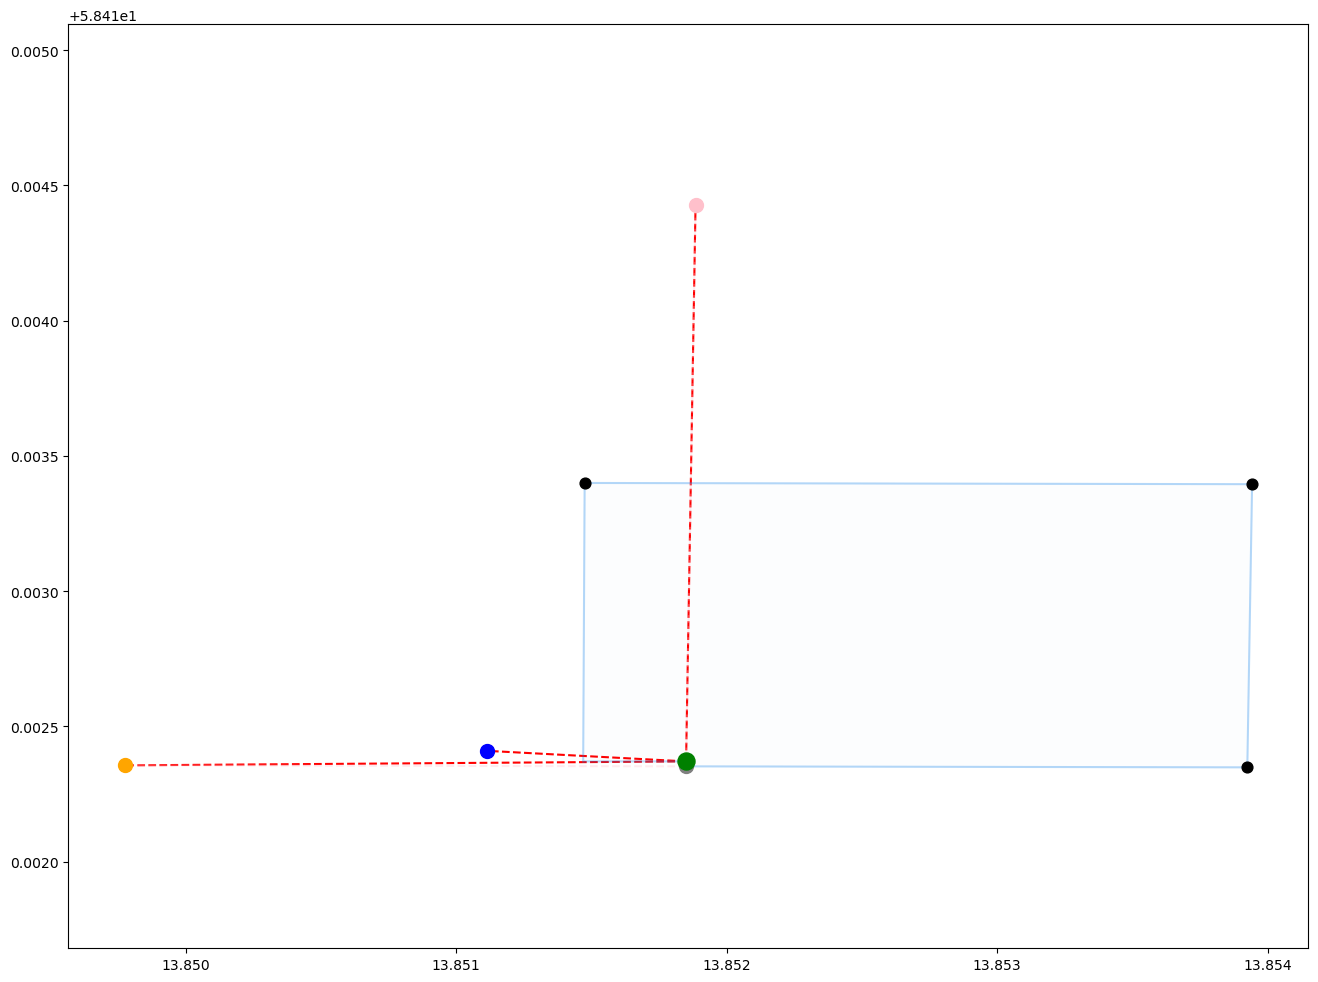

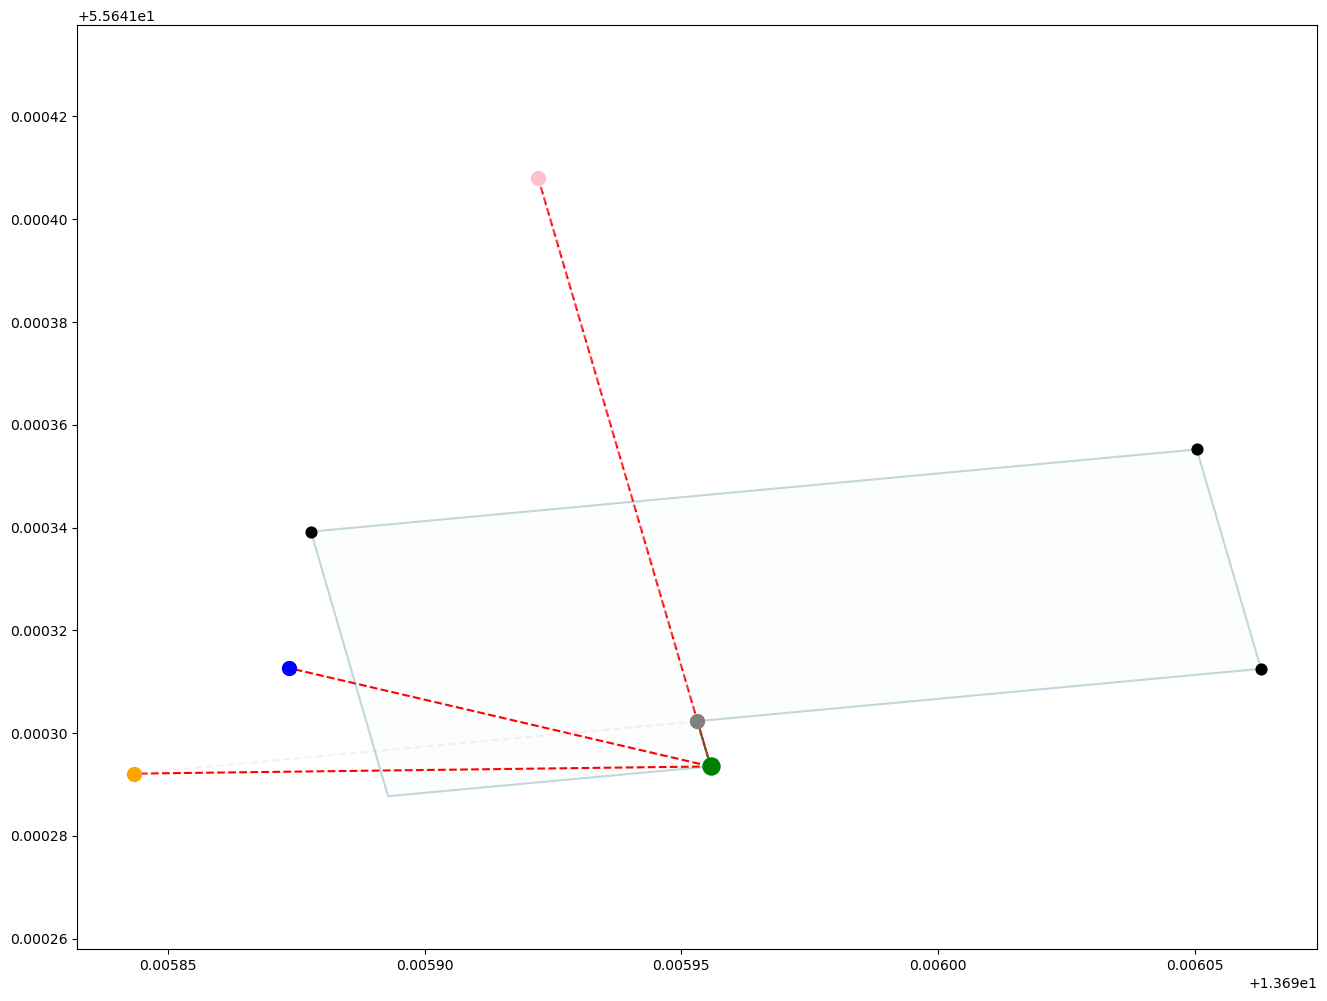

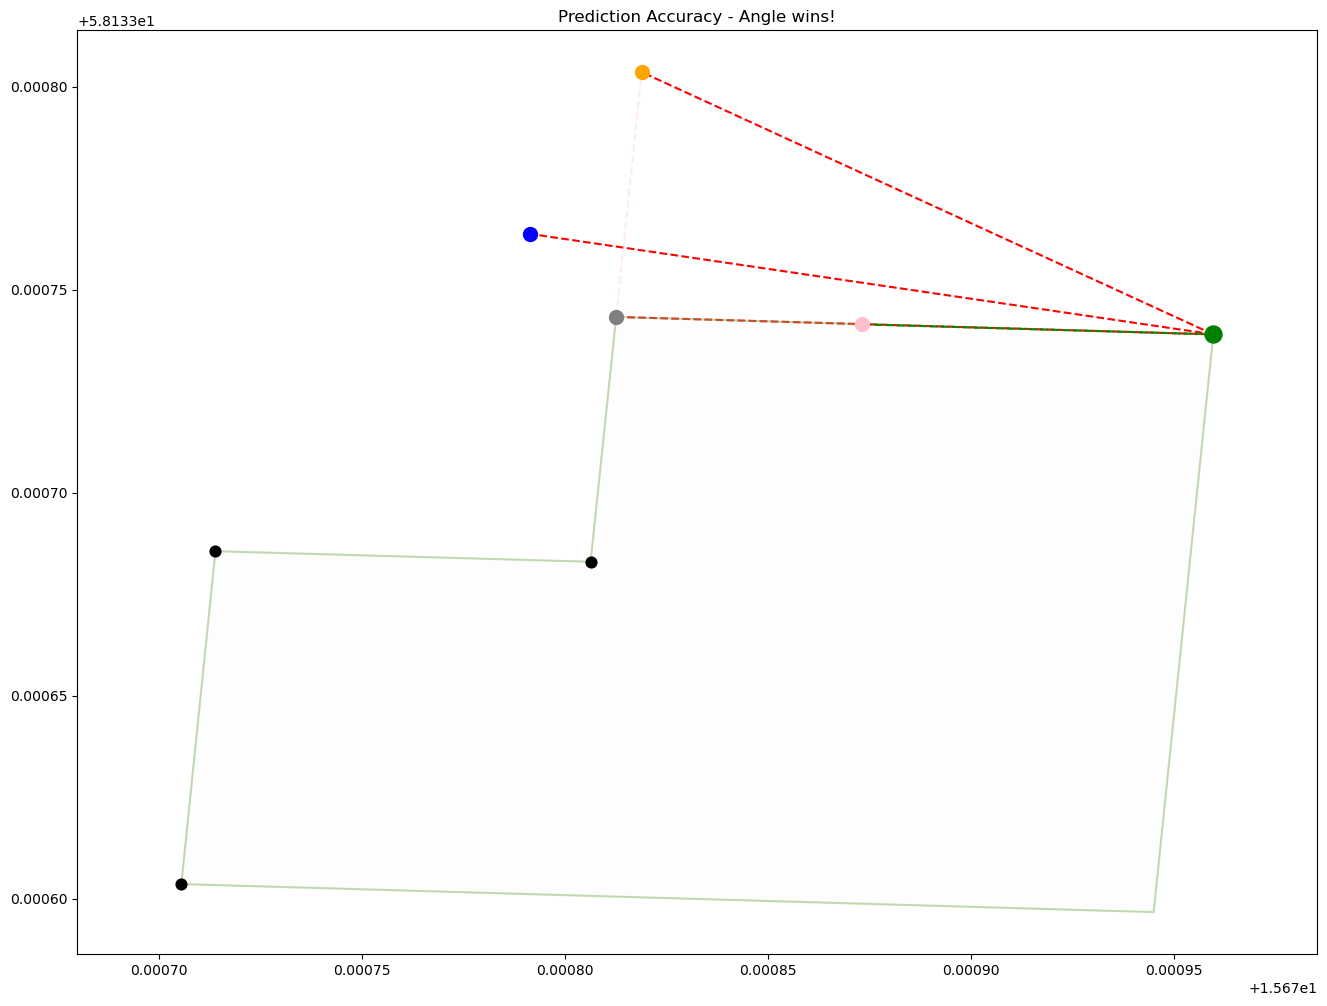

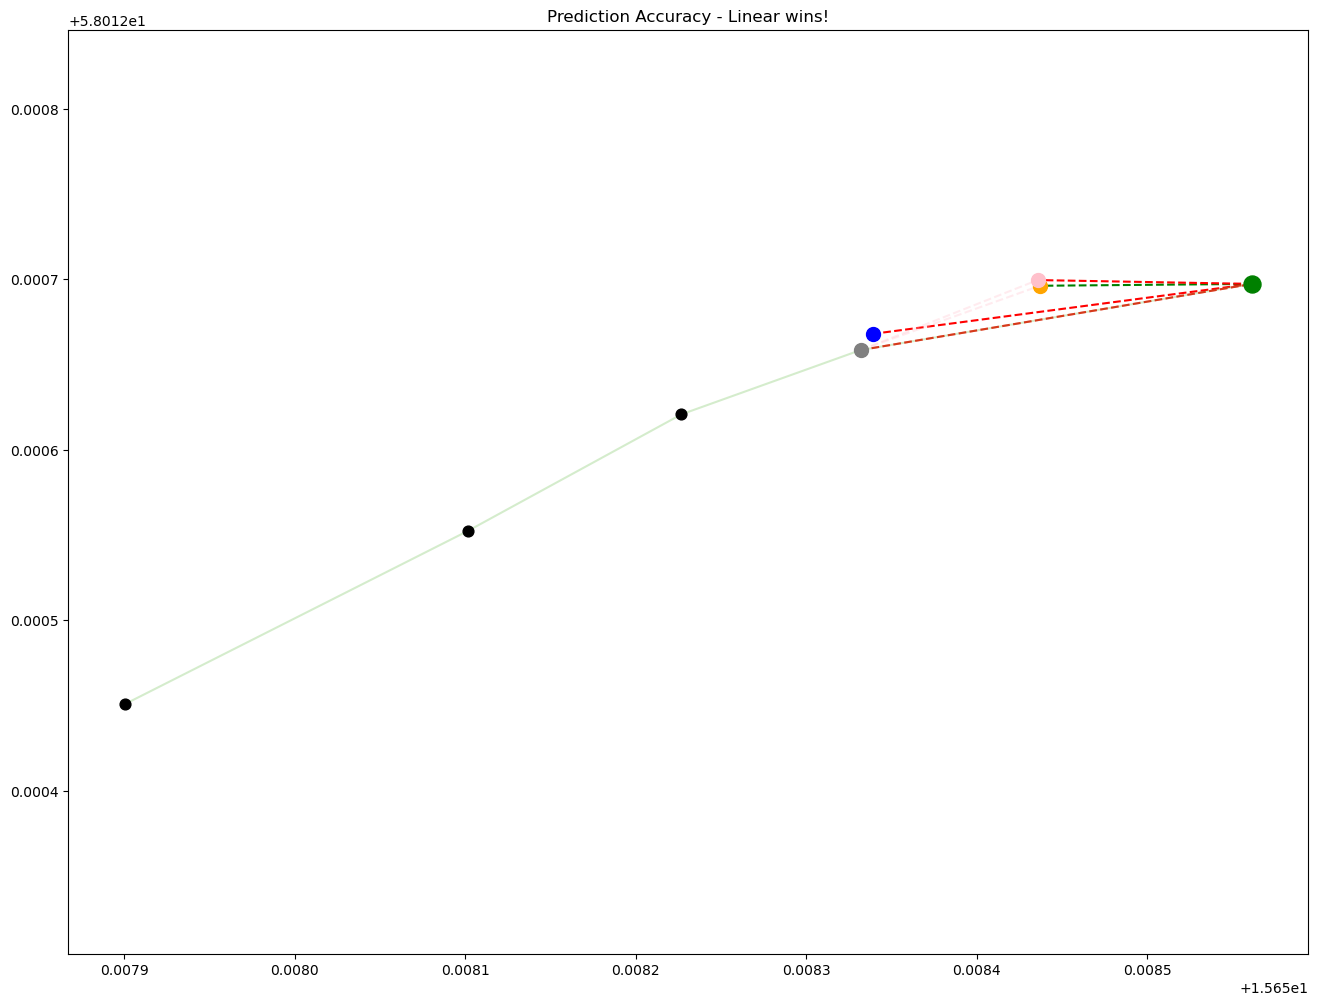

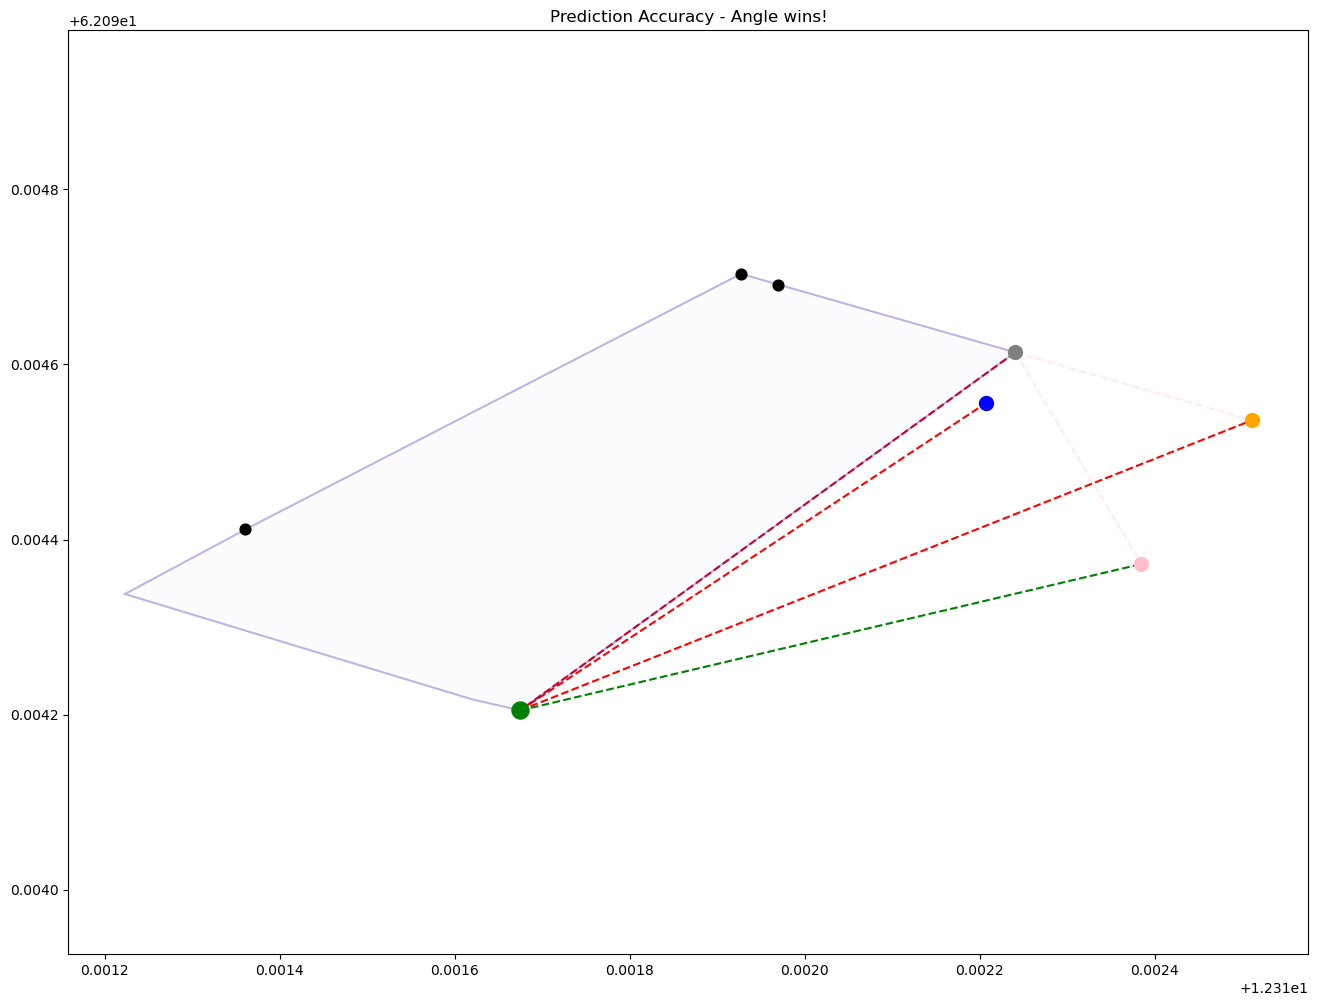

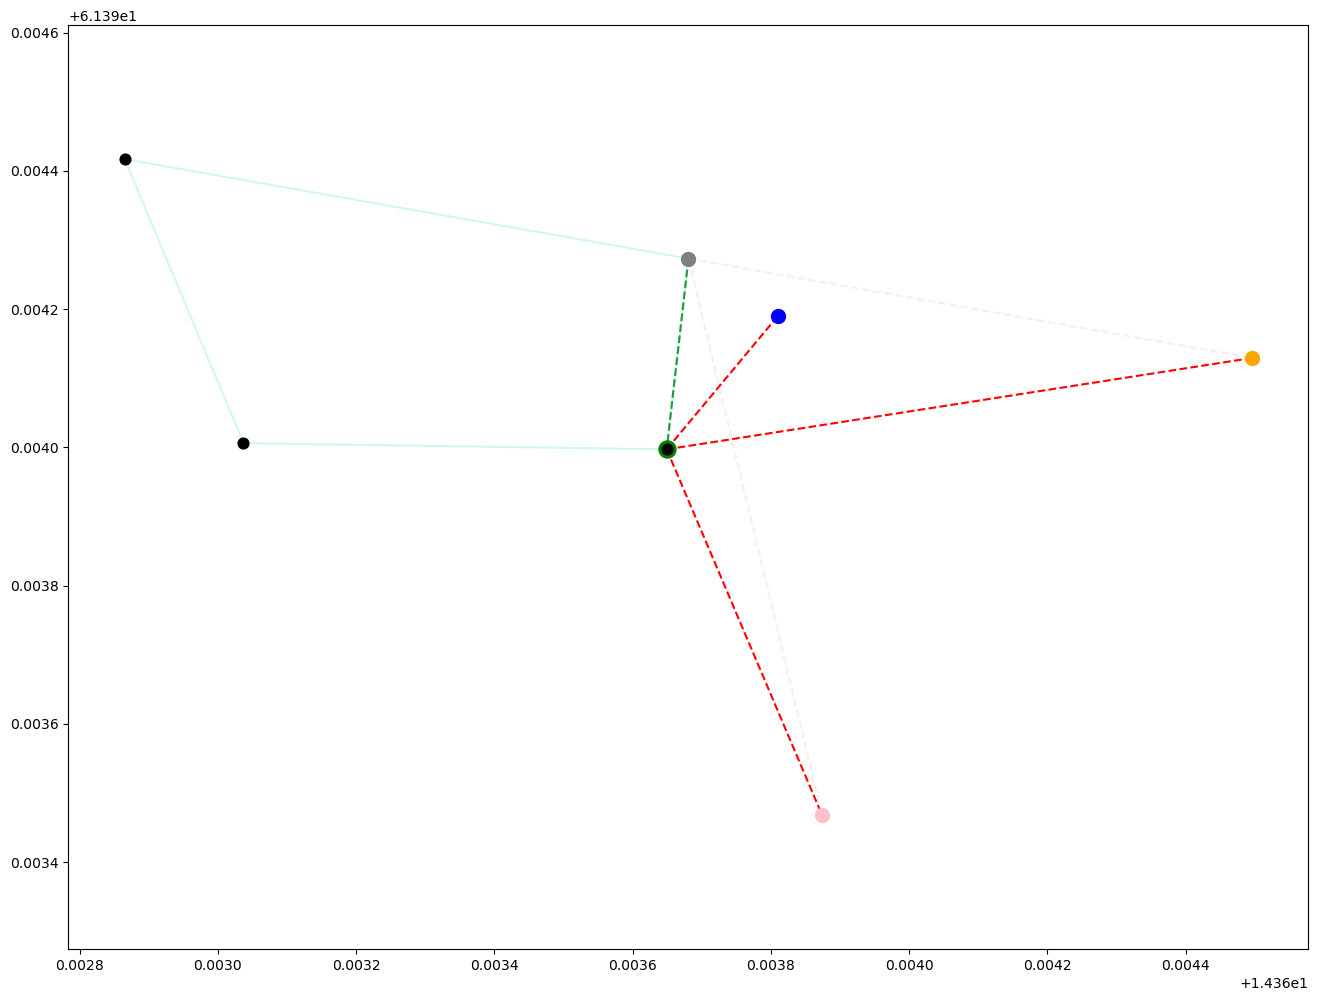

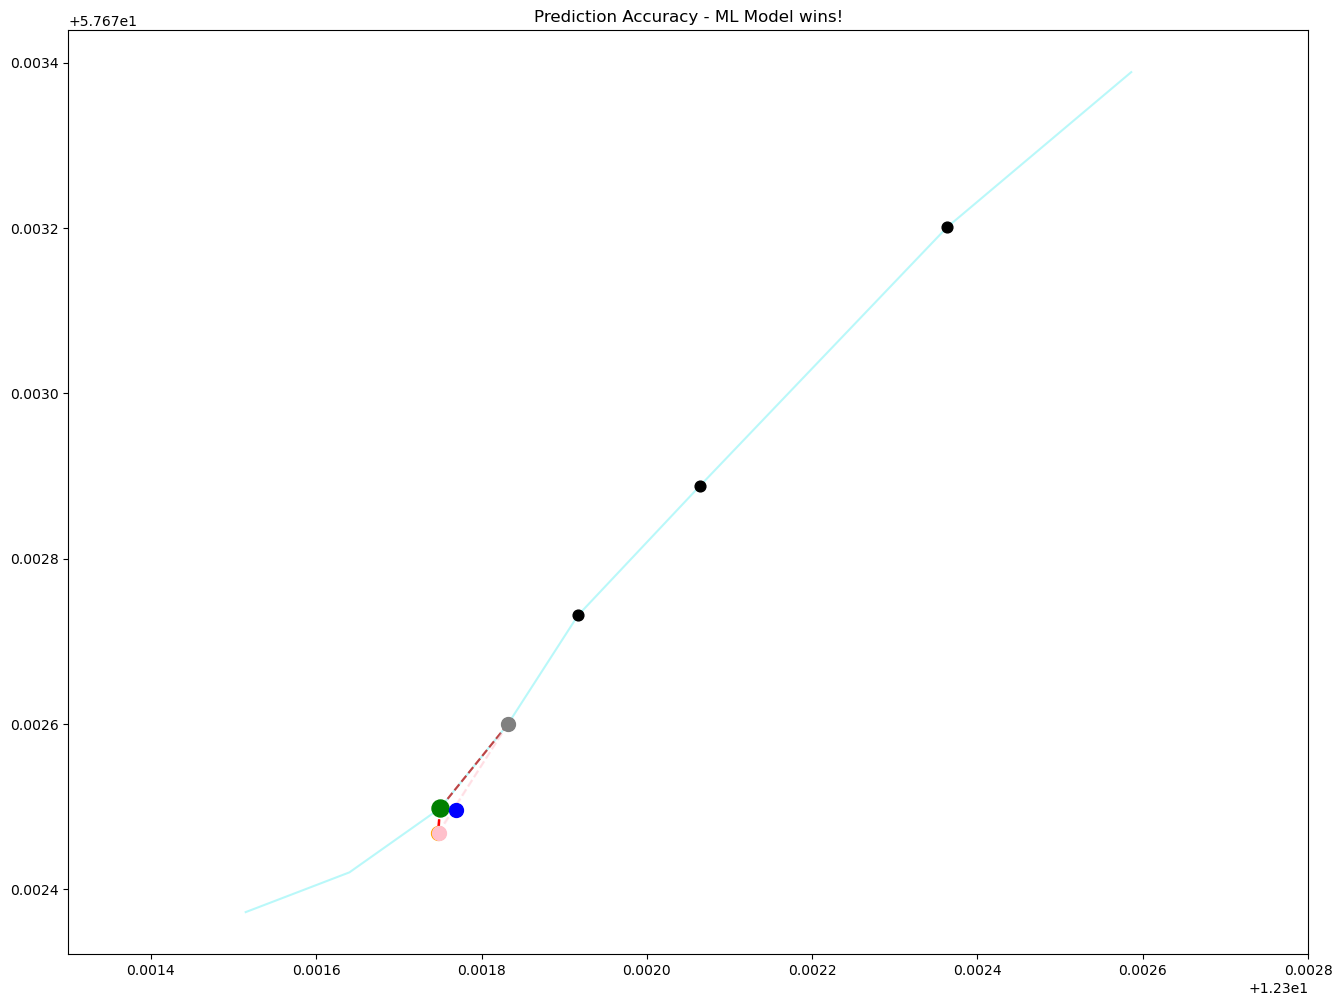

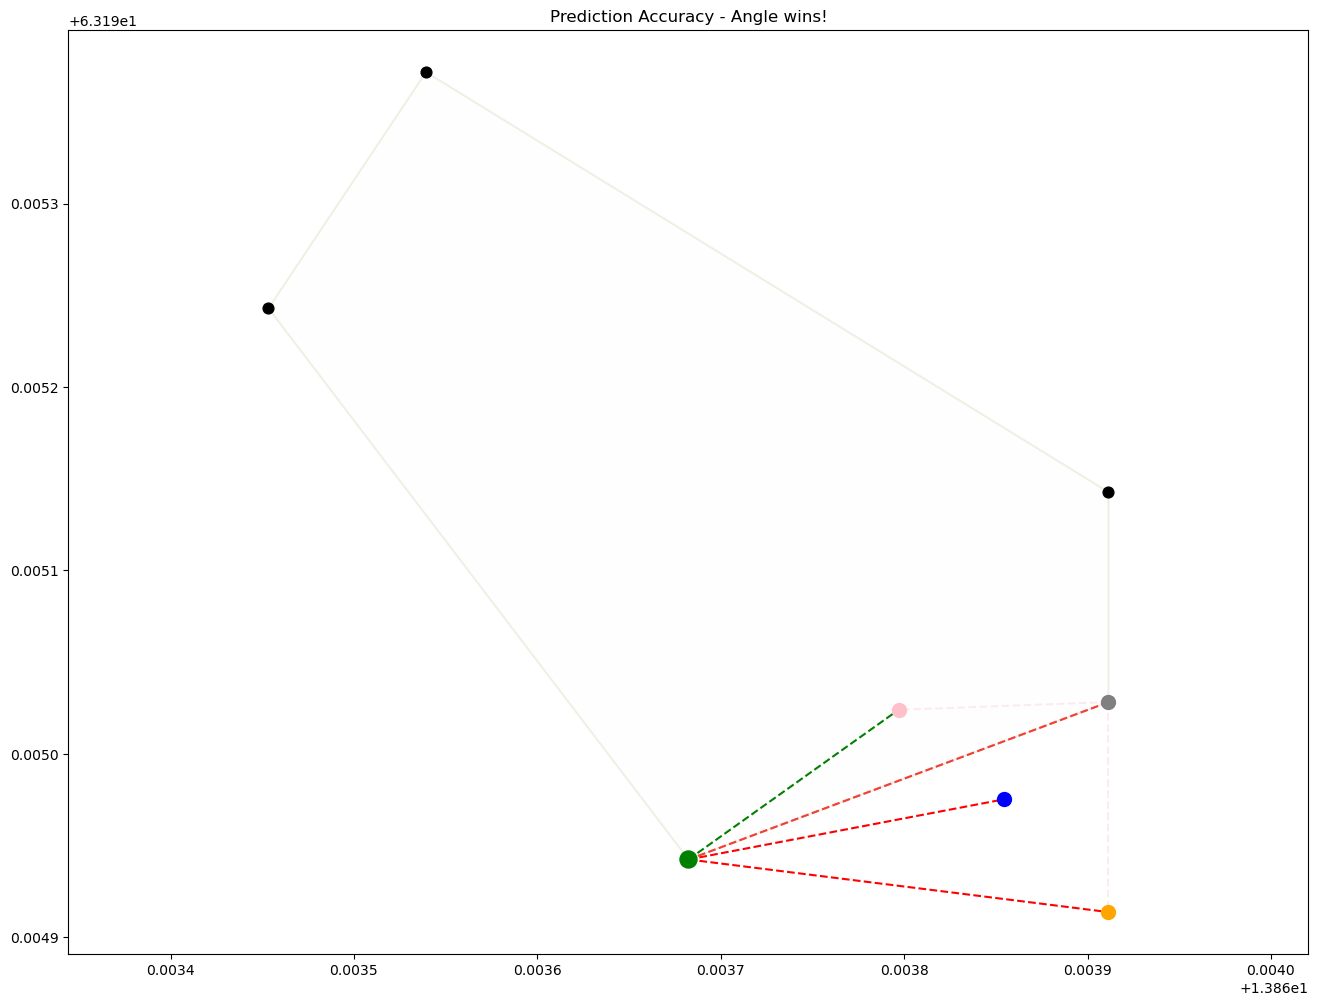

ML Model was better than None in: 5197 / 7684    ( 67.634045% )
Total MSE ML Model: 2.436460545948572
Total MSE None: 2.968253600000036
MSE Ratio (lower means ML Model is better): 82.083975%

Linear was better than None in: 3814 / 7684    ( 49.635606% )
Total MSE Linear: 2.9497033000013744
Total MSE None: 2.968253600000036
MSE Ratio (lower means Linear is better): 99.375043%

Angle was better than None in: 4327 / 7684    ( 56.311817% )
Total MSE Angle: 2.9550744845800665
Total MSE None: 2.968253600000036
MSE Ratio (lower means Angle is better): 99.555998%

MSE if per delta config: 1.735442234726813


In [ ]:
from intersection.plotting import plot_geometry, create_canvas, plot_raw_points, plot_raw_point, plot_line

PRINT_VALIDATION = False
DRAW_MODEL_PREDICT = True

def flat_to_coord(x, idx=None):
    sep = len(x) // 2
    if idx != None:
        return np.array([x[idx], x[sep + idx]]) if USE_FLAT_LIST else x[idx]
    else:
        return np.array([[x[idx], x[sep + idx]] for idx in range(sep)]) if USE_FLAT_LIST else x
    
def denormalize(content, offset):
    return np.array([[p[0] + offset[0], p[1] + offset[1]] for p in content]) if NORMALIZE_PLACEMENT else content

def linear_pred(x, x_normalized):
    if np.isnan(x[0][0]):
        return np.array([0, 0])
    elif np.isnan(x[1][0]):
        return x[0]
    else:
        return x[0] + (x[0] - x[1])
    
def angle_pred(x, x_normalized):
    if np.isnan(x[0][0]): # Zero coords
        return np.array([0, 0])
    elif np.isnan(x[1][0]): # One previous coord
        return x[0]
    elif np.isnan(x[2][0]): # Two previous coords
        return x[0] + (x[0] - x[1])
    else: # At least three points
        # a is first, b, c
        a, b, c = [x[0], x[1], x[2]]
        
        if True and not np.isnan(x[3][0]): # Avoid zig-zagging by taking the angle two steps back instead
             a, b, c = [b, c, x[3]]

        b_c = c - b
        b_a = a - b

        cosine_angle = np.dot(b_c, b_a) / (np.linalg.norm(b_c) * np.linalg.norm(b_a))
        angle = np.arccos(np.clip(cosine_angle, -1, 1))
        if np.cross(b_c, b_a) < 0:
            angle = -angle

        origin_vector = x[1] - x[0]
        x_rotated = (origin_vector[0] * np.cos(angle)) - (origin_vector[1] * np.sin(angle))
        y_rotated = (origin_vector[0] * np.sin(angle)) + (origin_vector[1] * np.cos(angle))
        res = np.array([x_rotated, y_rotated]) + x[0]
        
        # plot_raw_point(x[0], color="red", size=100)
        # plot_line(x[0], x[1], solid=False, color="red")
        # plot_raw_point(x[2], color="red", size=100)
        # plot_line(x[2], x[1], solid=False, color="orange")
        # plot_line(x[0], res, solid=False, color="green")
        # plt.axis('equal')
       
        return res

def eval_set(geoms, X, y):
    y_hat_all = model.predict(X)

    predictors = []
    ## Model
    predictor = {}
    predictor['func'] = lambda x_small, i, x_small_normalized: denormalize([y_hat_all[i]], normalization_offset[geoms[i]])[0]
    predictor['color'] = 'blue'
    predictor['draw'] = True
    predictor['name'] = "ML Model"
    predictors.append(predictor)

    ## Linear
    predictor = {}
    predictor['func'] = lambda x_small, i, x_small_normalized: linear_pred(x_small, x_small_normalized)
    predictor['color'] = 'orange'
    predictor['draw'] = True
    predictor['name'] = "Linear"
    predictor['extra_plot'] = lambda prev, y_pred, y_true: plot_line(prev, y_pred, solid=False, color=predictor['color'], alpha=0.3)
    predictors.append(predictor)

    ## Angle
    predictor = {}
    predictor['func'] = lambda x_small, i, x_small_normalized: angle_pred(x_small, x_small_normalized)
    predictor['color'] = 'pink'
    predictor['draw'] = True
    predictor['name'] = "Angle"
    predictor['extra_plot'] = lambda prev, y_pred, y_true: plot_line(prev, y_pred, solid=False, color=predictor['color'], alpha=0.3)
    predictors.append(predictor)

    
    all_errors = [] # Store errors/distances for all queries
    # TODO: Use test set instead!
    for i in range(len(y)):
        x_small_normalized = flat_to_coord(X[i][:MEMORY_SLOTS*2])
        x_small = denormalize(x_small_normalized, normalization_offset[geoms[i]])
        y_true = denormalize([y[i]], normalization_offset[geoms[i]])[0]
        prev = x_small[0]
        
        distances = []
        distances.append((abs(y_true[0] - prev[0]) + abs(y_true[1] - prev[1]))) # Default
        y_preds = []
    
        for pred_idx, pred in enumerate(predictors):
            y_preds.append(pred['func'](x_small, i, x_small_normalized))
            y_pred = y_preds[-1]
            distances.append(abs(y_true[0] - y_pred[0]) + abs(y_true[1] - y_pred[1]))
            if PRINT_VALIDATION:
                print(prev)
                print(f'{i + 1}: Diff: {y_true - y_pred}   predicted {y_pred}     distance {distances[-1]}')
                print(f'{i + 1}: Default: {y_true - prev}       was       {y_true})        distance {distances[0]}')
                print('Better:', 'YES' if distances[-1] < distances[0] else 'NO')
                print()

        all_errors.append(distances)

        if i % 1000 == 0: # Draw?
            win_idx = np.argmin(distances)
            col_head = 'grey'
            col_tail = 'black'
            col_error = 'red'
            col_correct = 'green'
            idx = geoms[i]
            create_canvas(no_frame=True)
            
            # Draw shape + points used in model
            plot_geometry(shape(df.iloc[idx]), alpha=0.5, fill_alpha=0.2)
            plot_raw_point(prev, color=col_head, size=100)
            plot_raw_point(y_true, color=col_correct, size=150)
            x_non_zero = list(filter(lambda x: not all(x == [np.NaN, np.NaN]), x_small[1:]))
            plot_raw_points(x_non_zero, color=col_tail, size=60)
            plot_line(prev, y_true, solid=False, color=col_correct if win_idx == 0 else col_error)

            for pred_idx, pred in enumerate(predictors):
                if pred['draw']:
                    y_pred = y_preds[pred_idx]
                    plot_raw_point(y_pred, color=pred['color'], size=100)
                    plot_line(y_true, y_pred, solid=False, color=col_correct if win_idx == pred_idx + 1 else col_error)
                    if win_idx == pred_idx + 1:
                        plt.title("Prediction Accuracy - " + pred['name'] + " wins!")
                    if "extra_plot" in pred:
                        pred['extra_plot'](prev, y_pred, y_true)
            plt.axis('equal')
            plt.show()

    none_tot_mse = sum(d[0] for d in all_errors)
    for pred_idx, pred in enumerate(predictors):
        pred_better_cnt = sum([1 if d[pred_idx + 1] < d[0] else 0 for d in all_errors])
        pred_tot_mse = sum(d[pred_idx + 1] for d in all_errors)
        name = pred['name']

        print(name, "was better than None in:", pred_better_cnt, '/', len(y), '   (', f'{(pred_better_cnt/len(y) * 100):f}%' , ')')
        print("Total MSE " + name + ":", pred_tot_mse)
        print("Total MSE None:", none_tot_mse)
        print("MSE Ratio (lower means " + name + " is better):", f'{(pred_tot_mse/none_tot_mse * 100):f}%')
        print()

    min_mse = sum(min(d) for d in all_errors)
    print("MSE if per delta config:", min_mse)

samples = len(X_validation)
eval_set(validation_geometries, X_validation[:samples], y_validation[:samples])